#  Basic demonstration of pyMCR

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pymcr.mcr import McrAls

# Define model system

## Spectra

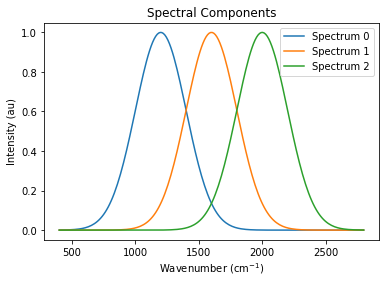

In [2]:
wn = np.linspace(400,2800,200)

n_components = 3

sp0 = np.exp(-(wn-1200)**2/(2*200**2))
sp1 = np.exp(-(wn-1600)**2/(2*200**2))
sp2 = np.exp(-(wn-2000)**2/(2*200**2))

plt.plot(wn, sp0, label='Spectrum 0')
plt.plot(wn, sp1, label='Spectrum 1')
plt.plot(wn, sp2, label='Spectrum 2')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.legend(loc='best')
plt.title('Spectral Components')

## Concentration map

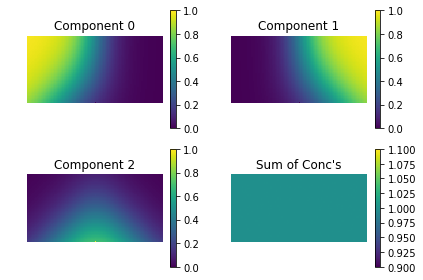

In [3]:
# Model starts off as 3 2D-Gaussian centered at (x*, y*)
# with standard deviation R (1 for each component).
# The sum to 1 constraint is then enforced.

x0 = 25
y0 = 25

x1 = 75
y1 = 25

x2 = 50
y2 = 50

R = 20

M=50  # rows (Y)
N= 100  # cols (X)

# Init concentration map
conc = np.zeros((M,N,n_components))

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R**2))*np.exp(-(Y-y0)**2/(2*R**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R**2))*np.exp(-(Y-y1)**2/(2*R**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R**2))*np.exp(-(Y-y2)**2/(2*R**2))

conc /= conc.sum(axis=-1)[:,:,None]

# Find the maximum concentration (per component)
# and set to conc = 1 (and make the rest 0's)
# This just ensures that each component has a pure
# pixel somewhere within the image
for num in range(n_components):
    idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
    tmp = np.zeros(3)
    tmp[num] = 1
    conc[idx[0],idx[1],:] = 1*tmp

plt.figure(figsize=(6,4))
for num in range(3):
    plt.subplot(2,2,num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    plt.title('Component {}'.format(num))

plt.subplot(2,2,4)
plt.imshow(conc.sum(axis=-1))
plt.colorbar()
plt.axis('off')
plt.title('Sum of Conc\'s')
plt.tight_layout()

In [4]:
# Stack 3 spectral vectors into 1 matrix
spectra = np.vstack((sp0, sp1, sp2))

# Hyperspectral image (HSI)
hsi = np.dot(conc, spectra)

# Perform MCR-ALS

## With spectral guess

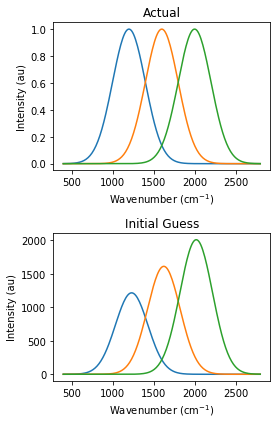

In [5]:
# Poor guess
initial_spectra = spectra*wn

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(212)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.tight_layout()

In [6]:
mcrals = McrAls(max_iter=500, tol_mse=1e-8, tol_dif_conc=1e-8, tol_dif_spect=1e-8)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_spectra=initial_spectra)

iteration 1 : MSE 3.88e-04
iteration 2 : MSE 8.11e-05
iteration 3 : MSE 3.15e-05
iteration 4 : MSE 1.71e-05
iteration 5 : MSE 1.10e-05
iteration 6 : MSE 7.69e-06
iteration 7 : MSE 5.66e-06
iteration 8 : MSE 4.33e-06
iteration 9 : MSE 3.41e-06
iteration 10 : MSE 2.74e-06
iteration 11 : MSE 2.25e-06
iteration 12 : MSE 1.87e-06
iteration 13 : MSE 1.58e-06
iteration 14 : MSE 1.35e-06
iteration 15 : MSE 1.17e-06
iteration 16 : MSE 1.01e-06
iteration 17 : MSE 8.90e-07
iteration 18 : MSE 7.86e-07
iteration 19 : MSE 6.99e-07
iteration 20 : MSE 6.24e-07
iteration 21 : MSE 5.61e-07
iteration 22 : MSE 5.07e-07
iteration 23 : MSE 4.61e-07
iteration 24 : MSE 4.20e-07
iteration 25 : MSE 3.84e-07
iteration 26 : MSE 3.53e-07
iteration 27 : MSE 3.25e-07
iteration 28 : MSE 3.01e-07
iteration 29 : MSE 2.79e-07
iteration 30 : MSE 2.60e-07
iteration 31 : MSE 2.42e-07
iteration 32 : MSE 2.27e-07
iteration 33 : MSE 2.13e-07
iteration 34 : MSE 2.00e-07
iteration 35 : MSE 1.88e-07
iteration 36 : MSE 1.78e-07
i

iteration 289 : MSE 1.57e-08
iteration 290 : MSE 1.57e-08
iteration 291 : MSE 1.56e-08
iteration 292 : MSE 1.56e-08
iteration 293 : MSE 1.56e-08
iteration 294 : MSE 1.55e-08
iteration 295 : MSE 1.55e-08
iteration 296 : MSE 1.54e-08
iteration 297 : MSE 1.54e-08
iteration 298 : MSE 1.54e-08
iteration 299 : MSE 1.53e-08
iteration 300 : MSE 1.53e-08
iteration 301 : MSE 1.53e-08
iteration 302 : MSE 1.52e-08
iteration 303 : MSE 1.52e-08
iteration 304 : MSE 1.51e-08
iteration 305 : MSE 1.51e-08
iteration 306 : MSE 1.51e-08
iteration 307 : MSE 1.50e-08
iteration 308 : MSE 1.50e-08
iteration 309 : MSE 1.50e-08
iteration 310 : MSE 1.49e-08
iteration 311 : MSE 1.49e-08
iteration 312 : MSE 1.49e-08
iteration 313 : MSE 1.48e-08
iteration 314 : MSE 1.48e-08
iteration 315 : MSE 1.47e-08
iteration 316 : MSE 1.47e-08
iteration 317 : MSE 1.47e-08
iteration 318 : MSE 1.46e-08
iteration 319 : MSE 1.46e-08
iteration 320 : MSE 1.46e-08
iteration 321 : MSE 1.45e-08
iteration 322 : MSE 1.45e-08
iteration 323 

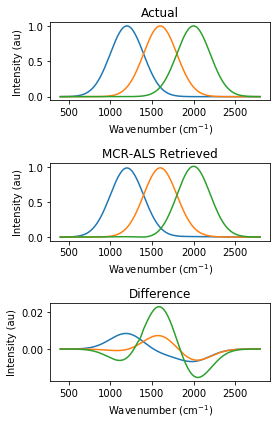

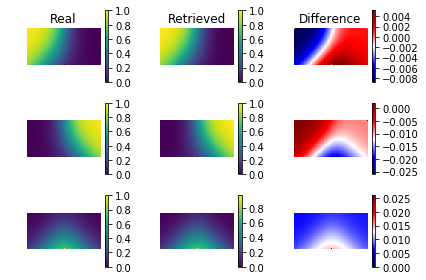

In [7]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

## With concentration guess

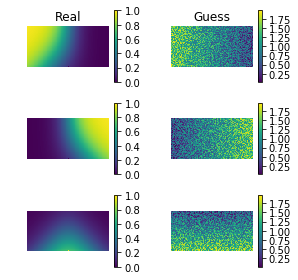

In [8]:
# Poor guess
initial_conc = np.zeros((M,N,3))
initial_conc[...,0] = np.dot(np.ones(M)[:,None], (np.arange(N,0,-1)/N)[None,:])
initial_conc[...,1] = np.dot(np.ones(M)[:,None], (np.arange(N)/N)[None,:])
initial_conc[...,2] = np.dot((np.arange(M)/M)[:,None], np.ones(N)[None,:])
initial_conc += np.random.rand(M,N,3)

plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(initial_conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Guess')
plt.tight_layout()
    
# plt.figure(figsize=(4,6))
# plt.subplot(211)
# plt.plot(wn, spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

# plt.subplot(212)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.tight_layout()

In [9]:
mcrals = McrAls(max_iter=500, tol_mse=1e-8, tol_dif_conc=1e-8, tol_dif_spect=1e-8)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_conc=initial_conc.reshape((-1, 3)))
# mcrals.fit(hsi.reshape((-1, wn.size)), initial_conc=conc.reshape((-1, 3)))

iteration 1 : MSE 2.14e-02
iteration 2 : MSE 4.30e-03
iteration 3 : MSE 4.21e-04
iteration 4 : MSE 1.24e-04
iteration 5 : MSE 5.70e-05
iteration 6 : MSE 3.36e-05
iteration 7 : MSE 2.29e-05
iteration 8 : MSE 1.71e-05
iteration 9 : MSE 1.35e-05
iteration 10 : MSE 1.11e-05
iteration 11 : MSE 9.36e-06
iteration 12 : MSE 8.09e-06
iteration 13 : MSE 7.13e-06
iteration 14 : MSE 6.36e-06
iteration 15 : MSE 5.74e-06
iteration 16 : MSE 5.24e-06
iteration 17 : MSE 4.81e-06
iteration 18 : MSE 4.45e-06
iteration 19 : MSE 4.14e-06
iteration 20 : MSE 3.87e-06
iteration 21 : MSE 3.64e-06
iteration 22 : MSE 3.43e-06
iteration 23 : MSE 3.24e-06
iteration 24 : MSE 3.07e-06
iteration 25 : MSE 2.92e-06
iteration 26 : MSE 2.78e-06
iteration 27 : MSE 2.65e-06
iteration 28 : MSE 2.54e-06
iteration 29 : MSE 2.43e-06
iteration 30 : MSE 2.33e-06
iteration 31 : MSE 2.24e-06
iteration 32 : MSE 2.16e-06
iteration 33 : MSE 2.08e-06
iteration 34 : MSE 2.01e-06
iteration 35 : MSE 1.94e-06
iteration 36 : MSE 1.88e-06
i

iteration 290 : MSE 1.48e-07
iteration 291 : MSE 1.47e-07
iteration 292 : MSE 1.45e-07
iteration 293 : MSE 1.44e-07
iteration 294 : MSE 1.43e-07
iteration 295 : MSE 1.42e-07
iteration 296 : MSE 1.41e-07
iteration 297 : MSE 1.40e-07
iteration 298 : MSE 1.39e-07
iteration 299 : MSE 1.38e-07
iteration 300 : MSE 1.37e-07
iteration 301 : MSE 1.36e-07
iteration 302 : MSE 1.35e-07
iteration 303 : MSE 1.34e-07
iteration 304 : MSE 1.33e-07
iteration 305 : MSE 1.32e-07
iteration 306 : MSE 1.31e-07
iteration 307 : MSE 1.30e-07
iteration 308 : MSE 1.29e-07
iteration 309 : MSE 1.28e-07
iteration 310 : MSE 1.27e-07
iteration 311 : MSE 1.26e-07
iteration 312 : MSE 1.25e-07
iteration 313 : MSE 1.24e-07
iteration 314 : MSE 1.23e-07
iteration 315 : MSE 1.22e-07
iteration 316 : MSE 1.21e-07
iteration 317 : MSE 1.20e-07
iteration 318 : MSE 1.19e-07
iteration 319 : MSE 1.18e-07
iteration 320 : MSE 1.18e-07
iteration 321 : MSE 1.17e-07
iteration 322 : MSE 1.16e-07
iteration 323 : MSE 1.15e-07
iteration 324 

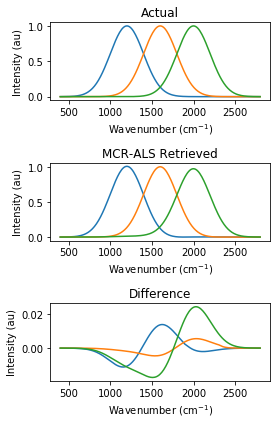

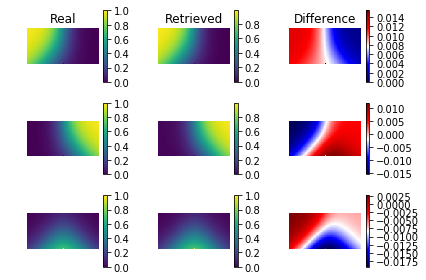

In [10]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()